In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tch
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
import torchvision.transforms as trans
import torch.nn as nn

from time import time

In [2]:
class CustomMNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Load your NumPy data and labels
data = np.load('dataset.npy')
labels = np.load('labels.npy')

In [4]:
# Define the size of the training set (e.g., 80%)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

In [5]:
# Split the data and labels into training and testing subsets
train_data, test_data = np.split(data, [train_size])
train_labels, test_labels = np.split(labels, [train_size])


In [6]:
# Create custom datasets
train_dataset = CustomMNISTDataset(train_data, train_labels, transform=trans.ToTensor())
test_dataset = CustomMNISTDataset(test_data, test_labels, transform=trans.ToTensor())

In [7]:
print("No. of Training examples: ",len(train_dataset)) 
print("No. of Test examples: ",len(test_dataset)) 

No. of Training examples:  47996
No. of Test examples:  11999


In [8]:
train_dataset[0][0][0]

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 198.,   0.,
          18.,   0.,   0.,   0.],
        [  0.,   0.,   0., 253.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,  93.,   0.,   0.,   0.,   0.,   0.,   0.,  93., 253.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,  49., 186., 114.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0., 253.,   0.,   0., 240.,   0.,   0.,   0., 253.,   0.,  81.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 107.,   0.,   0.,   0.,  70., 251.,   0.,   0.,   0.,
           0.,   0., 253., 241.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,
           0.,   0., 253.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         253.,   0.,   0.,   0.],
        [ 80.,   0.,


The Number is :  4 



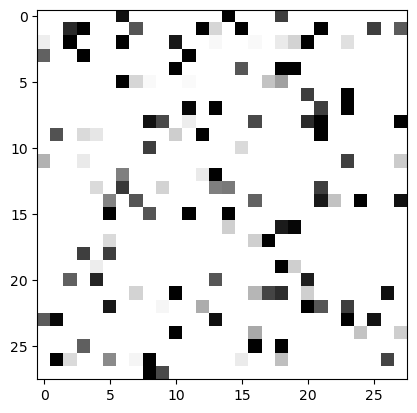

In [9]:
image,label = test_dataset[0] #to display the first image in test dataset along with its corresponding number
plt.imshow(image.numpy().squeeze(), cmap='gray_r');
print("\nThe Number is : " ,label,"\n")

In [10]:
print("Shape of image : ",image.shape)
print("Shape of label : ",label.shape)

Shape of image :  torch.Size([1, 28, 28])
Shape of label :  ()


In [11]:
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)

In [12]:
# 28 * 28 = 784
input1 = 784 
# 2/3 of 784 = 523.6
hidden = 523
# Output = [0,1,2,3,4,5,6,7,8,9]
output = 10 

In [13]:
model = nn.Sequential(nn.Linear(input1, hidden), 
                       nn.LeakyReLU(), 
                       nn.Linear(hidden, output), 
                        nn.LogSoftmax(dim=1)) 
lossfn = nn.NLLLoss()
optimize = tch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5) 

In [14]:
time_start = time()
epochs = 18
loss_arr = np.array([])
for num in range(epochs):
    run = 0
    for images, labels in train_loader:
        # Ensure the data type is consistent
        images = images.view(images.shape[0], -1).to(dtype=tch.float32)
        optimize.zero_grad()
        output = model(images)
        loss = lossfn(output, labels)
        loss.backward()
        optimize.step()
        run += loss.item()
    else:
        print("Epoch Number : {} = Loss : {}".format(num, run/len(train_loader)))
        loss_arr = np.append(loss_arr, run/len(train_loader))
Elapsed = (time()-time_start)/60
print("\nTraining Time (in minutes) : ", Elapsed)


Epoch Number : 0 = Loss : 0.5660386573664437
Epoch Number : 1 = Loss : 0.1207367992907166
Epoch Number : 2 = Loss : 0.07620386167915058
Epoch Number : 3 = Loss : 0.05222721290630489
Epoch Number : 4 = Loss : 0.03853687850121616
Epoch Number : 5 = Loss : 0.025136082632686227
Epoch Number : 6 = Loss : 0.01876960130564555
Epoch Number : 7 = Loss : 0.013153546177451575
Epoch Number : 8 = Loss : 0.006885851570585402
Epoch Number : 9 = Loss : 0.0031759155169682886
Epoch Number : 10 = Loss : 0.0017941568265660735
Epoch Number : 11 = Loss : 0.0011669968130769526
Epoch Number : 12 = Loss : 0.0008899252166703775
Epoch Number : 13 = Loss : 0.0006756294615244229
Epoch Number : 14 = Loss : 0.0005823905485418379
Epoch Number : 15 = Loss : 0.0005163599315467993
Epoch Number : 16 = Loss : 0.0004623861211955327
Epoch Number : 17 = Loss : 0.0004229931834222178

Training Time (in minutes) :  0.6769835313161214


In [15]:
correct=0
all = 0
for images,labels in test_dataset:
  img = images.view(1, 784).to(dtype=tch.float32)
  with tch.no_grad():
    logps = model(img)   
  ps = tch.exp(logps)
  probab = list(ps.numpy()[0])
  prediction = probab.index(max(probab))
  truth = labels
  if(truth == prediction):
    correct += 1
  all += 1

print("Number Of Images Tested : ", all)
print("Model Accuracy : ", (correct/all))

Number Of Images Tested :  11999
Model Accuracy :  0.9714976248020668


Predicted Digit = 2
Actual Digit = 2


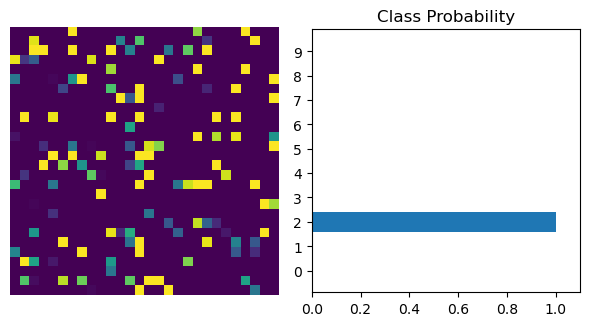

In [16]:
def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
img,label=train_dataset[np.random.randint(0,10001)] 
image=img.view(1, 784).to(dtype=tch.float32)
with tch.no_grad():
  logps = model(image)
ps = tch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
print("Actual Digit =",label)
view_classify(image.view(1, 28, 28), ps)

Predicted Digit = 8
Predicted Digit = 6
Predicted Digit = 5
Predicted Digit = 3
Predicted Digit = 8


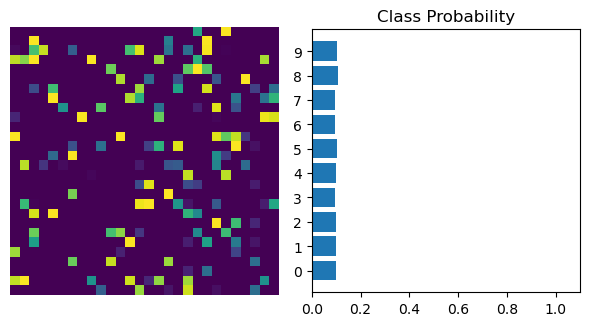

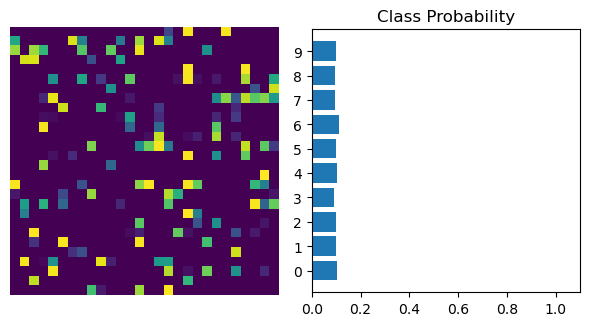

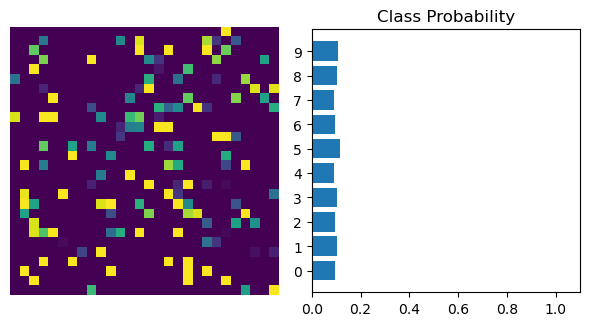

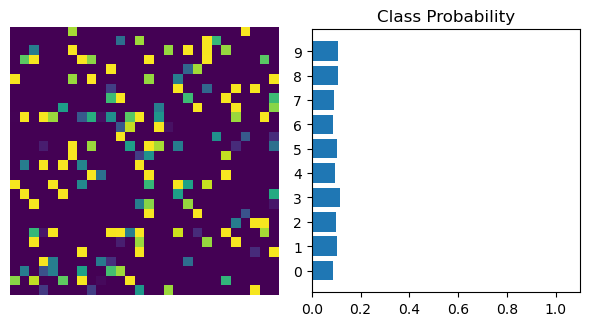

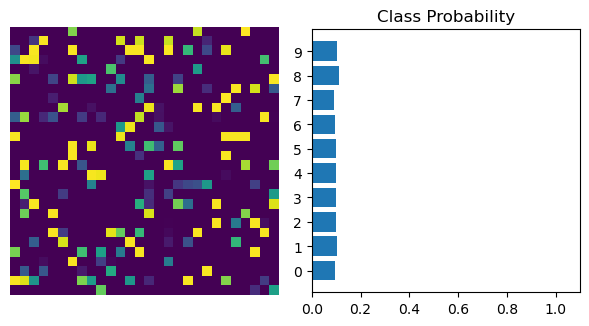

In [17]:
# Predicting the images in the images folder
from PIL import Image
from torch.autograd import Variable

def predict_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((28, 28))
    img = trans.ToTensor()(img)
    img = img.view(1, 784).to(dtype=tch.float32)
    with tch.no_grad():
        logps = model(img)
    ps = tch.exp(logps)
    probab = list(ps.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    view_classify(img.view(1, 28, 28), ps)

for i in range(1, 6):
    predict_image("images/im-"+str(i)+".png")


LOSS VS ITERATION

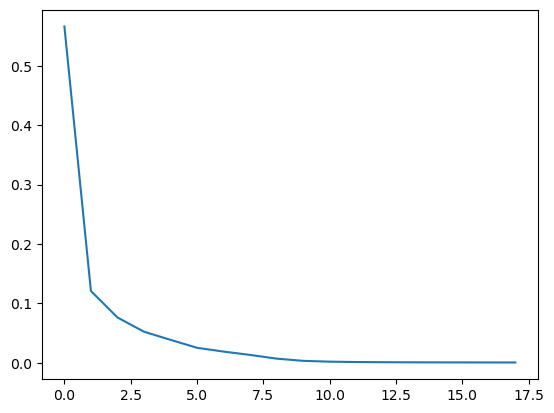

In [18]:
# Loss vs Epochs
plt.plot(loss_arr)